In [2]:
import numpy as np
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from matplotlib import pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
train=pd.read_csv('/content/drive/MyDrive/Yahoodataset/synthetic_1.csv')

In [5]:
i = train[((train.is_anomaly == 1))].index

In [6]:
i

Int64Index([658, 659, 893, 894], dtype='int64')

In [7]:
train = train.drop(i)

In [8]:
del train['is_anomaly']

In [9]:

train['timestamp'] = pd.to_datetime(train['timestamp'])
train['timestamp'].min(),train['timestamp'].max()

(Timestamp('1970-01-01 00:00:01.416726'),
 Timestamp('1970-01-01 00:00:01.421838'))

In [10]:
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=train['timestamp'], y=train['value'], name='time vs value'))
fig.update_layout(showlegend=True, title='time vs value')
fig.show()

In [11]:
test=pd.read_csv("/content/drive/MyDrive/Yahoodataset/synthetic_2.csv")

In [12]:
del test['is_anomaly']

In [13]:
test['timestamp'] = pd.to_datetime(test['timestamp'])
test['timestamp'].min(),test['timestamp'].max()

(Timestamp('1970-01-01 00:00:01.416726'),
 Timestamp('1970-01-01 00:00:01.421838'))

In [14]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test['timestamp'], y=test['value'], name='time vs value'))
fig.update_layout(showlegend=True, title='time vs value')
fig.show()

In [15]:
train, test = train,test
train.shape, test.shape

((1417, 2), (1421, 2))

In [16]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler = scaler.fit(train[['value']])

train['value'] = scaler.transform(train[['value']])
test['value'] = scaler.transform(test[['value']])

In [17]:
TIME_STEPS=288

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])
    
    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['value']], train['value'])
X_test, y_test = create_sequences(test[['value']], test['value'])

print(f'Training shape: {X_train.shape}')
print(f'Testing shape: {X_test.shape}')

Training shape: (1129, 288, 1)
Testing shape: (1133, 288, 1)


In [18]:
model = keras.Sequential(
    [
        layers.Input(shape=(X_train.shape[1], X_train.shape[2])),
        layers.Conv1D(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1D(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(
            filters=16, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Dropout(rate=0.2),
        layers.Conv1DTranspose(
            filters=32, kernel_size=7, padding="same", strides=2, activation="relu"
        ),
        layers.Conv1DTranspose(filters=1, kernel_size=7, padding="same"),
    ]
)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="mae")
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 144, 32)           256       
_________________________________________________________________
dropout (Dropout)            (None, 144, 32)           0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 72, 16)            3600      
_________________________________________________________________
conv1d_transpose (Conv1DTran (None, 144, 16)           1808      
_________________________________________________________________
dropout_1 (Dropout)          (None, 144, 16)           0         
_________________________________________________________________
conv1d_transpose_1 (Conv1DTr (None, 288, 32)           3616      
_________________________________________________________________
conv1d_transpose_2 (Conv1DTr (None, 288, 1)            2

In [19]:
history = model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=32,
    validation_split=0.1,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor="val_loss", patience=3, mode="min")
    ],
)

Epoch 1/1000
32/32 [==============================] - 2s 44ms/step - loss: 0.8845 - val_loss: 1.1197
Epoch 2/1000
32/32 [==============================] - 1s 27ms/step - loss: 0.8806 - val_loss: 1.0533
Epoch 3/1000
32/32 [==============================] - 1s 27ms/step - loss: 0.8862 - val_loss: 0.9796
Epoch 4/1000
32/32 [==============================] - 1s 27ms/step - loss: 0.8796 - val_loss: 1.0328
Epoch 5/1000
32/32 [==============================] - 1s 26ms/step - loss: 0.8751 - val_loss: 1.0786
Epoch 6/1000
32/32 [==============================] - 1s 26ms/step - loss: 0.8771 - val_loss: 0.9347
Epoch 7/1000
32/32 [==============================] - 1s 26ms/step - loss: 0.8835 - val_loss: 0.9740
Epoch 8/1000
32/32 [==============================] - 1s 26ms/step - loss: 0.8488 - val_loss: 1.0200
Epoch 9/1000
32/32 [==============================] - 1s 26ms/step - loss: 0.8536 - val_loss: 0.9242
Epoch 10/1000
32/32 [==============================] - 1s 26ms/step - loss: 0.8410 - val_lo

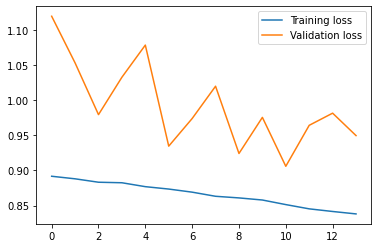

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend();

In [21]:
# Get train MAE loss.
x_train_pred = model.predict(X_train)


In [22]:
x_train_pred

array([[[ 0.5952135 ],
        [ 0.6857114 ],
        [ 0.75635177],
        ...,
        [ 1.4663106 ],
        [ 1.4195862 ],
        [ 1.4489596 ]],

       [[ 0.6073379 ],
        [ 0.6977028 ],
        [ 0.76705295],
        ...,
        [ 1.4771327 ],
        [ 1.4303381 ],
        [ 1.4588364 ]],

       [[ 0.6238741 ],
        [ 0.7144373 ],
        [ 0.7814382 ],
        ...,
        [ 1.4810765 ],
        [ 1.4347935 ],
        [ 1.4632033 ]],

       ...,

       [[-0.14422885],
        [-0.136185  ],
        [-0.19008043],
        ...,
        [-0.1170212 ],
        [-0.07047144],
        [-0.0596209 ]],

       [[-0.14217606],
        [-0.1341843 ],
        [-0.18778011],
        ...,
        [-0.07823516],
        [-0.04683917],
        [-0.037653  ]],

       [[-0.13002853],
        [-0.1203507 ],
        [-0.1722236 ],
        ...,
        [-0.04352076],
        [-0.02245038],
        [-0.01428745]]], dtype=float32)

In [23]:
X_train

array([[[ 0.00931646],
        [ 0.02923364],
        [ 0.08524417],
        ...,
        [ 1.37326993],
        [ 1.36197783],
        [ 1.35887004]],

       [[ 0.02923364],
        [ 0.08524417],
        [ 0.12213125],
        ...,
        [ 1.36197783],
        [ 1.35887004],
        [ 1.38245768]],

       [[ 0.08524417],
        [ 0.12213125],
        [ 0.15003011],
        ...,
        [ 1.35887004],
        [ 1.38245768],
        [ 1.38644633]],

       ...,

       [[-1.38775279],
        [-1.39653086],
        [-1.39884447],
        ...,
        [-0.19443243],
        [-0.14783526],
        [-0.14605248]],

       [[-1.39653086],
        [-1.39884447],
        [-1.38067682],
        ...,
        [-0.14783526],
        [-0.14605248],
        [-0.07612751]],

       [[-1.39884447],
        [-1.38067682],
        [-1.36239077],
        ...,
        [-0.14605248],
        [-0.07612751],
        [-0.02179861]]])

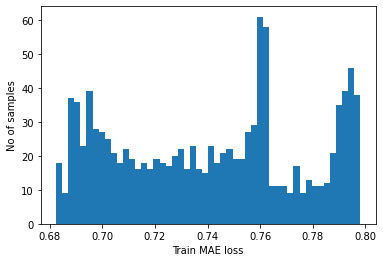

Reconstruction error threshold:  0.7981158539539608


In [24]:
train_mae_loss = np.mean(np.abs(x_train_pred - X_train), axis=1)

plt.hist(train_mae_loss, bins=50)
plt.xlabel("Train MAE loss")
plt.ylabel("No of samples")
plt.show()

# Get reconstruction loss threshold.
threshold = np.max(train_mae_loss)
print("Reconstruction error threshold: ", threshold)

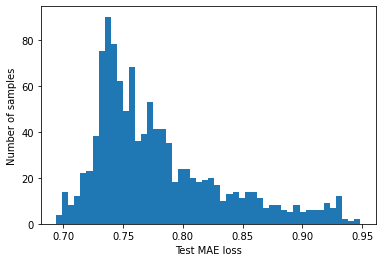

In [25]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');

In [26]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['value'] = test[TIME_STEPS:]['value']

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['timestamp'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['timestamp'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [27]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

(317, 5)

In [28]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['timestamp'], y=scaler.inverse_transform(test_score_df['value']), name='values'))
fig.add_trace(go.Scatter(x=anomalies['timestamp'], y=scaler.inverse_transform(anomalies['value']), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()

In [29]:
for_eval = pd.read_csv('/content/drive/MyDrive/Yahoodataset/synthetic_2.csv')

In [30]:
test_score_df

,timestamp,value,loss,threshold,anomaly
288,1970-01-01 00:00:01.417762800,-0.018983,0.784087,0.798116,False
289,1970-01-01 00:00:01.417766400,-0.071150,0.785789,0.798116,False
290,1970-01-01 00:00:01.417770000,-0.098359,0.783517,0.798116,False
291,1970-01-01 00:00:01.417773600,-0.122443,0.785324,0.798116,False
292,1970-01-01 00:00:01.417777200,-0.240566,0.785705,0.798116,False
...,...,...,...,...,...
1416,1970-01-01 00:00:01.421823600,1.034856,0.935065,0.798116,True
1417,1970-01-01 00:00:01.421827200,0.920675,0.935583,0.798116,True
1418,1970-01-01 00:00:01.421830800,0.936277,0.941408,0.798116,True
1419,1970-01-01 00:00:01.421834400,0.921900,0.945190,0.798116,True


In [31]:
for_eval

,timestamp,value,is_anomaly
0,1416726000,27.109888,0
1,1416729600,40.776442,0
2,1416733200,122.541469,0
3,1416736800,168.222793,0
4,1416740400,196.942108,0
...,...,...,...
1416,1421823600,1027.439798,0
1417,1421827200,914.594224,0
1418,1421830800,930.013750,0
1419,1421834400,915.804942,0


In [32]:
df21 = for_eval.iloc[288:]

In [33]:
df21

,timestamp,value,is_anomaly
288,1417762800,-14.074233,0
289,1417766400,-65.631832,0
290,1417770000,-92.522519,0
291,1417773600,-116.324788,0
292,1417777200,-233.065809,0
...,...,...,...
1416,1421823600,1027.439798,0
1417,1421827200,914.594224,0
1418,1421830800,930.013750,0
1419,1421834400,915.804942,0


In [34]:
test_score_df['anomaly']

288     False
289     False
290     False
291     False
292     False
        ...  
1416     True
1417     True
1418     True
1419     True
1420     True
Name: anomaly, Length: 1133, dtype: bool

In [35]:
anomaly_pred = test_score_df['anomaly']

In [36]:
anomaly_pred

288     False
289     False
290     False
291     False
292     False
        ...  
1416     True
1417     True
1418     True
1419     True
1420     True
Name: anomaly, Length: 1133, dtype: bool

In [37]:
df21 = df21.join(anomaly_pred)

In [38]:
df21

,timestamp,value,is_anomaly,anomaly
288,1417762800,-14.074233,0,False
289,1417766400,-65.631832,0,False
290,1417770000,-92.522519,0,False
291,1417773600,-116.324788,0,False
292,1417777200,-233.065809,0,False
...,...,...,...,...
1416,1421823600,1027.439798,0,True
1417,1421827200,914.594224,0,True
1418,1421830800,930.013750,0,True
1419,1421834400,915.804942,0,True


In [39]:
df21[['anomaly']] *= 1

In [40]:
df21

,timestamp,value,is_anomaly,anomaly
288,1417762800,-14.074233,0,0
289,1417766400,-65.631832,0,0
290,1417770000,-92.522519,0,0
291,1417773600,-116.324788,0,0
292,1417777200,-233.065809,0,0
...,...,...,...,...
1416,1421823600,1027.439798,0,1
1417,1421827200,914.594224,0,1
1418,1421830800,930.013750,0,1
1419,1421834400,915.804942,0,1


In [41]:
anomaly_pred

288     False
289     False
290     False
291     False
292     False
        ...  
1416     True
1417     True
1418     True
1419     True
1420     True
Name: anomaly, Length: 1133, dtype: bool

In [42]:
actual_anom1 = df21['is_anomaly']

In [43]:
actual_anom1

288     0
289     0
290     0
291     0
292     0
       ..
1416    0
1417    0
1418    0
1419    0
1420    0
Name: is_anomaly, Length: 1133, dtype: int64

In [44]:
from sklearn.metrics import accuracy_score

accuracy_score(actual_anom1, anomaly_pred)

0.7193292144748455

In [45]:
from sklearn.metrics import confusion_matrix
confusion_matrix(actual_anom1, anomaly_pred)

array([[811, 313],
       [  5,   4]])

In [46]:
from sklearn.metrics import classification_report
print(classification_report(actual_anom1, anomaly_pred))

              precision    recall  f1-score   support

           0       0.99      0.72      0.84      1124
           1       0.01      0.44      0.02         9

    accuracy                           0.72      1133
   macro avg       0.50      0.58      0.43      1133
weighted avg       0.99      0.72      0.83      1133

